# Adaboost Classification

In this notebook, I will work through the implementation of a adaboost classifier. Specifically, the algorithm implemented will be as specified in Freund & Schapire 1997. I will use the breast cancer classification dataset to test this code.

In [1]:
## imports ##
import numpy as np
import pandas as pd
from typing import Dict, Any, List, Tuple
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold,cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,make_scorer
from sklearn.ensemble import RandomForestClassifier

Let's now create a class that will encapsulate the adaboost algorithm:

In [2]:
## adaboost classifier ##
class AdaBoostClassifier(object):
    #initializer
    def __init__(self, 
                 weak_learner : Any, 
                 n_elements : int = 100, 
                 record_training_metrics : bool = False) -> None:
        self.weak_learner    = weak_learner
        self.n_elements      = n_elements
        self.f               = []
        self.model_weights   = []
        self.f1s             = []
        self.mean_loss       = []
        self.record_training = record_training_metrics
        
    #destructor
    def __del__(self) -> None:
        del self.weak_learner
        del self.n_elements
        del self.f
        del self.model_weights
        del self.f1s
        del self.mean_loss
        del self.record_training
       
    #private loss function
    def __compute_loss(self,y_pred : np.array, y_train : np.array) -> np.array:
        #compute the loss function
        loss = (y_pred != y_train).astype(int)
        #return computed loss
        return(loss)
    
    #private function to compute model weights
    def __compute_alpha(self, w : np.array, loss : np.array) -> float:
        #compute the error rate
        err = np.sum(np.multiply(w,loss)) / np.sum(w)
        #compute the adaptive weight
        alpha = np.log((1-err)/err)
        #store alpha
        self.model_weights.append(alpha)
        #return computed alpha
        return(alpha)

    #private function to compute training metrics for n-trained weak learners
    def __compute_training_metrics(self, X_train : np.array, y_train : np.array) -> Tuple[float,float]:
        #initialize output
        y_pred = np.zeros((X_train.shape[0]))
        #traverse ensemble to generate predictions
        for model,mw in zip(self.f,self.model_weights):
            y_pred += mw*model.predict(X_train)
        #perform sign operation
        y_pred = np.round(y_pred).astype(int)
        y_pred = np.where(y_pred<=0,-1,1)
        #compute metrics
        f1   = f1_score(y_train,y_pred)
        loss = np.mean(self.__compute_loss(y_pred,y_train))
        #return computed metrics
        return(f1,loss)
    
    #public function to train the ensemble
    def fit(self, X_train : np.array, y_train : np.array) -> None:
        #check that y_train consists of {-1,1}
        if (np.unique(y_train).shape[0] != 2) or (np.min(y_train) != -1) or (np.max(y_train) != 1):
            raise Exception('Training labels are not formatted to {-1,+1}')
        #initialize sample weights, residuals, & model array
        w              = np.ones((y_train.shape[0])) / y_train.shape[0]
        self.residuals = []
        self.f         = []
        #loop through the specified number of iterations in the ensemble
        for _ in range(self.n_elements):
            #make a copy of the weak learner
            model = clone(self.weak_learner)
            #fit the current weak learner on the dataset
            model.fit(X_train,y_train,sample_weight=w)
            #obtain predictions from the current weak learner
            y_pred = model.predict(X_train)
            #compute the loss
            loss = self.__compute_loss(y_pred,y_train)
            #compute the adaptive weight
            alpha = self.__compute_alpha(w,loss)
            #update sample weights
            w *= np.exp(alpha*loss)
            #append resulting model
            self.f.append(model)
            #append current training metrics
            if self.record_training:
                f1,mean_loss = self.__compute_training_metrics(X_train,y_train)
                self.f1s.append(f1)
                self.mean_loss.append(mean_loss)
        
    #public function to return training f1 scores
    def get_f1s(self) -> List:
        return(self.f1s)
    
    #public function to return mean training loss
    def get_loss(self) -> List:
        return(self.mean_loss)
 
    #public function to return model parameters
    def get_params(self, deep : bool = False) -> Dict:
        return {'weak_learner':self.weak_learner,
                'n_elements':self.n_elements,
                'record_training_metrics':self.record_training}

    #public function to generate predictions
    def predict(self, X_test : np.array) -> np.array:
        #initialize output
        y_pred = np.zeros((X_test.shape[0]))
        #traverse ensemble to generate predictions
        for model,mw in zip(self.f,self.model_weights):
            y_pred += mw*model.predict(X_test)
        #perform sign operation
        y_pred = np.round(y_pred).astype(int)
        y_pred = np.where(y_pred<=0,-1,1)
        #return predictions
        return(y_pred)

## Adaboost Classification

### Load Classification Dataset

Here I'll load the breast cancer dataset. Note I already analysed these data in Article II - Logistic Regression.

In [3]:
## load classification dataset ##
data = load_breast_cancer()
X    = data.data
y    = data.target

In [4]:
#properly format labels
y = np.where(y==0,-1,1)

### Investigate Training Metrics

In this section, I want to check the effects of increasing ensemble size. Specifically, we'll check that the F1 score of the ensemble increases as more weak learners are added. Conversely, the loss should decrease as more weak learners are added to the ensemble. I will also initialise the weak learner, which in our case will be a classification decision stump:

In [5]:
## initialize a weak learner ##
weak_m = DecisionTreeClassifier(max_depth=1)

In [6]:
## train the adaboost classifier ##
clf = AdaBoostClassifier(weak_learner=weak_m, record_training_metrics=True)
clf.fit(X,y)

In [7]:
## get training metrics ##
#obtain F1 scores
f1 = clf.get_f1s()
#obtain loss
loss = clf.get_loss()

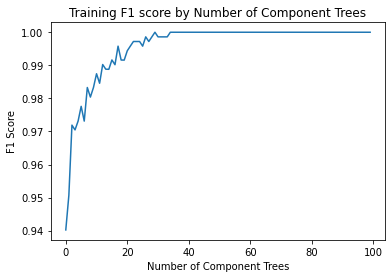

In [8]:
## plot the training F1 scores ##
plt.plot(f1)
plt.title('Training F1 score by Number of Component Trees')
plt.xlabel('Number of Component Trees')
plt.ylabel('F1 Score')
plt.show()

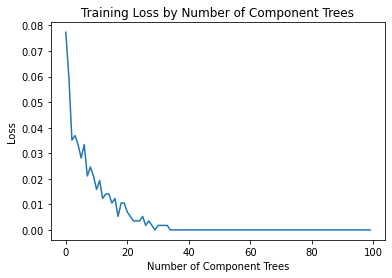

In [9]:
## plot the training loss ##
plt.plot(loss)
plt.title('Training Loss by Number of Component Trees')
plt.xlabel('Number of Component Trees')
plt.ylabel('Loss')
plt.show()

The plots indicate our implementation of Adaboost is functioning as we would expect: the F1 score increases, and the loss decreases, as the number of trees included in the ensemble becomes larger. Optimal performance appears to be reached at an ensemble size of approximately 35 trees.

### Investigate Performance

Here I will use 10-fold cross-validation to measure the performance of the adaboost classifier:

In [10]:
## define the scoring metrics ##
scoring_metrics = {'accuracy' : make_scorer(accuracy_score), 
                   'precision': make_scorer(precision_score),
                   'recall'   : make_scorer(recall_score),
                   'f1'       : make_scorer(f1_score)}

In [11]:
## perform cross-validation for n_elements=35 ##
#define the model
clf = AdaBoostClassifier(weak_learner=weak_m, n_elements=35)
#cross validate
dcScores = cross_validate(clf,X,y,cv=StratifiedKFold(10),scoring=scoring_metrics)
#report results
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))
print('Mean F1: %.2f' % np.mean(dcScores['test_f1']))

Mean Accuracy: 0.97
Mean Precision: 0.97
Mean Recall: 0.98
Mean F1: 0.97


We can compare these results with the Adaboost classifier available from scikit-learn:

In [12]:
## import adaboost classifier from scikit-learn ##
from sklearn.ensemble import AdaBoostClassifier

In [13]:
## perform cross-validation for n_estimators=35 ##
#define the model
clf = AdaBoostClassifier(base_estimator=weak_m, n_estimators=35)
#cross validate
dcScores = cross_validate(clf,X,y,cv=StratifiedKFold(10),scoring=scoring_metrics)
#report results
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))
print('Mean F1: %.2f' % np.mean(dcScores['test_f1']))

Mean Accuracy: 0.96
Mean Precision: 0.96
Mean Recall: 0.97
Mean F1: 0.97


We can see there is a slight difference between the two Adaboost models, with better performance seen with the model implemented in this notebook. Note however that the Adaboost classifier available through scikit-learn does not follow the Freund & Schapire 1997 algorithm, but instead follows the SAMME.R implementation.

Now let's compare our results with a lone weak learner, and a Random Forest Classifier with default hyper parameters:

In [14]:
#cross validate
dcScores = cross_validate(weak_m,X,y,cv=StratifiedKFold(10),scoring=scoring_metrics)
#report results
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))
print('Mean F1: %.2f' % np.mean(dcScores['test_f1']))

Mean Accuracy: 0.89
Mean Precision: 0.89
Mean Recall: 0.95
Mean F1: 0.91


In [15]:
#declare random forest
clf = RandomForestClassifier()
#cross validate
dcScores = cross_validate(clf,X,y,cv=StratifiedKFold(10),scoring=scoring_metrics)
#report results
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))
print('Mean F1: %.2f' % np.mean(dcScores['test_f1']))

Mean Accuracy: 0.97
Mean Precision: 0.97
Mean Recall: 0.98
Mean F1: 0.97


Model | Number of Elements | Accuracy | Precision | Recall | F1
--- | --- | --- | --- | --- | ---
Custom Adaboost | 35 | 0.97 | 0.97 | 0.98 | 0.97
Scikit-learn Adaboost | 35 | 0.96 | 0.96 | 0.97 | 0.97
Decision Stump | NA | 0.89 | 0.89 | 0.95 | 0.91
Scikit-Learn Random Forest | 100 | 0.97 | 0.97 | 0.98 | 0.97

Our implementation of the Adaboost algorithm, along with the Random Forest yields the best overall results from this comparison. However, the scikit-learn Adaboost model performs only marginally worse. Note that the Random Forest Classifier includes 100 individual trees by default. Unsurprising, the lone Decision Stump yields the worst results.